In [8]:
import os
import sys
sys.path.append("../..")
os.environ["CUDA_VISIBLE_DEVICES"]="1"
from openTSNE import TSNE
import torch

from train_router_mdeberta_v3 import RouterDataset, RouterModule
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from transformers import T5EncoderModel, T5Tokenizer, AutoTokenizer, DebertaV2Model


device="cuda"
# dataset_paths = ["../../datasets/split2_model7/mmlu_test.json", "../../datasets/split2_model7/gsm8k-test.json", "../../datasets/split2_model7/cmmlu_test.json","../../datasets/split2_model7/arc_challenge_test.json", "../../datasets/split2_model7/humaneval_test.json", "../../datasets/split2_model7/MATH_prealgebra.json", "../../datasets/split2_model7/mbpp.json", "../../datasets/split2_model7/ceval.json"]
# data_types = ["probability", "multi_attempt",  "probability",  "probability" ,"multi_attempt", "multi_attempt", "multi_attempt", "probability"]

# dataset_paths = ["../../datasets/split2_model7/javascript.json"]
# data_types = ["multi_attempt"]

dataset_paths = ["../../datasets/split2_model7/humaneval_test.json", "../../datasets/split2_model7_cluster/humaneval_train.json"]
data_types = ["multi_attempt","multi_attempt"]

# trained_router_path = "/data/home/chensh/projects/LLM_router/logs/router_debug/ablation_clw/clw_1/slw_0_clw_1_clw_2_0_cos_tk_3_lk_3_lr_5e-5_step_1000_t_1_seed_5/best_training_model.pth"

# trained_router_path = "/data/home/chensh/projects/LLM_router/logs/paper_result/ablation_K/slw_0_tk_1_lk_6_lr_5e-5_step_1000_t_1_seed_2/best_training_model.pth"

trained_router_path = "/data/home/chensh/projects/LLM_router/logs/paper_result/one_task/humaneval/tk_3_lk_3_lr_5e-5_step_1000_t_1_seed_0/best_model.pth"

tokenizer = AutoTokenizer.from_pretrained("/data/home/chensh/data/huggingface_model/microsoft/mdeberta-v3-base", truncation_side='left', padding=True)
encoder_model = DebertaV2Model.from_pretrained("/data/home/chensh/data/huggingface_model/microsoft/mdeberta-v3-base").to("cuda")



# router_datasets = [RouterDataset(data_path, data_type=data_types[i], dataset_id=i, size=2000) for i, data_path in enumerate(dataset_paths)]
# for router_dataset in router_datasets:
#     router_dataset.register_tokenizer(tokenizer)
# router_dataset = ConcatDataset(router_datasets)
# router_dataloader = DataLoader(router_dataset, batch_size=64)

router_model = RouterModule(encoder_model, hidden_state_dim=768, node_size=7, similarity_function="cos").to(device)

state_dict = torch.load(trained_router_path)
router_model.load_state_dict(state_dict)


/data/home/chensh/miniconda3/envs/vllm/lib/python3.9/site-packages/transformers/convert_slow_tokenizer.py:550: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


<All keys matched successfully>

In [9]:
import torch.nn as nn
from collections import Counter

def count_tensor_elements(tensor):
    # 将张量展平为一维数组
    flattened_tensor = tensor.view(-1).tolist()

    # 使用Counter统计元素出现次数
    element_counts = Counter(flattened_tensor)

    return element_counts

def evaluation(router_model, dataset_paths, dataset_types, tokenizer, batch_size, device): 
    all_counts = {key:0 for key in range(router_model.node_size)}   
    result = {}
    with torch.no_grad():
        assert len(dataset_paths) == len(dataset_types)
        for index, data_path in enumerate(dataset_paths):
            print(data_path)
            test_dataset = RouterDataset(data_path=data_path)
            test_dataset.register_tokenizer(tokenizer)
            data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
            correct_predict = 0
            correct = 0
            for batch in data_loader:
                inputs, scores, _, _ = batch
                inputs = inputs.to(device)
                scores = scores.to(device)
                x, _ = router_model.forward(**inputs)
                softmax_x = nn.Softmax(dim=1)(x)
                _, max_index = torch.max(softmax_x, dim=1)
                _, target_max_index = torch.max(scores, dim=1)

                counts = count_tensor_elements(max_index)
                for element, count in counts.items():
                    all_counts[element] += count

                equals = max_index.eq(target_max_index)
                correct += equals.sum().item()

                if dataset_types[index] == "probability":
                    mask = torch.zeros_like(scores)
                    mask = mask.scatter_(1, max_index.unsqueeze(1), 1)
                    scores[scores > 0] = 1
                    correct_predict += (scores * mask).sum().item()
                elif dataset_types[index] == "multi_attempt":
                    mask = torch.zeros_like(scores)
                    mask = mask.scatter_(1, max_index.unsqueeze(1), 1)
                    correct_predict += (scores * mask).sum().item()

            acc_predict = correct_predict/len(test_dataset)
            acc = correct/len(test_dataset)
            print(f"acc_{data_path}:", acc_predict)
            print("acc", acc)
            result[data_path] = [acc, acc_predict]
    return result, all_counts

In [10]:
all_acount_list = []
for i in range(len(dataset_paths)):
   result, acount = evaluation(router_model, [dataset_paths[i]], [data_types[i]], tokenizer, 32, device)
   all_acount_list.append(acount)


../../datasets/split2_model7/humaneval_test.json
acc_../../datasets/split2_model7/humaneval_test.json: 0.5632653139075454
acc 0.2653061224489796
../../datasets/split2_model7_cluster/humaneval_train.json
acc_../../datasets/split2_model7_cluster/humaneval_train.json: 0.6139130633810292
acc 0.25217391304347825


In [17]:
[v/49 for v in all_acount_list[0].values()]


[0.0, 0.0, 0.0, 0.0, 0.20408163265306123, 0.0, 0.7959183673469388]

[{0: 6, 1: 1819, 2: 282, 3: 996, 4: 205, 5: 340, 6: 565}, {0: 0, 1: 780, 2: 2, 3: 1, 4: 30, 5: 0, 6: 506}, {0: 1, 1: 1178, 2: 619, 3: 797, 4: 189, 5: 235, 6: 456}, {0: 0, 1: 217, 2: 12, 3: 73, 4: 17, 5: 15, 6: 18}, {0: 2, 1: 3, 2: 0, 3: 1, 4: 21, 5: 1, 6: 21}, {0: 0, 1: 505, 2: 13, 3: 94, 4: 15, 5: 11, 6: 233}, {0: 13, 1: 422, 2: 1, 3: 0, 4: 0, 5: 0, 6: 64}, {0: 3, 1: 482, 2: 235, 3: 311, 4: 74, 5: 90, 6: 151}]
[[0.   0.   0.   0.   0.04 0.   0.03 0.  ]
 [0.43 0.59 0.34 0.62 0.06 0.58 0.84 0.36]
 [0.24 0.   0.23 0.21 0.02 0.11 0.   0.23]
 [0.07 0.   0.18 0.03 0.   0.01 0.   0.17]
 [0.05 0.02 0.05 0.05 0.43 0.02 0.   0.05]
 [0.08 0.   0.07 0.04 0.02 0.01 0.   0.07]
 [0.13 0.38 0.13 0.05 0.43 0.27 0.13 0.11]]


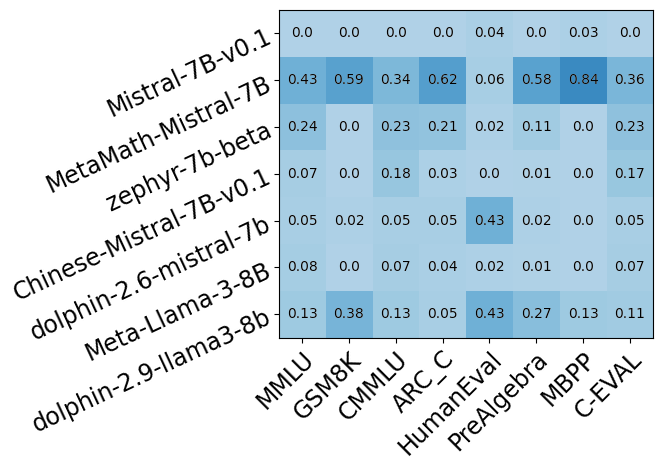

In [5]:
import matplotlib.pyplot as plt
import numpy as np



def plot_matrix(x_name, y_name, matrix, title, save_path):
    fig, ax = plt.subplots() 
    im = ax.imshow(matrix, cmap='Blues', vmin=-0.8, vmax=1.7)

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(x_name)), labels=x_name, fontsize=17)
    ax.set_yticks(np.arange(len(y_name)), labels=y_name, fontsize=17)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")
    plt.setp(ax.get_yticklabels(), rotation=25, ha="right",
            rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(x_name)):
        for j in range(len(y_name)):
            # if matrix[j, i] < 0.5:
            text = ax.text(i, j, matrix[j, i],
                            ha="center", va="center", color="w")
            # else:
            text = ax.text(i, j, matrix[j, i], ha="center", va="center", color="black")
            
    # ax.set_title(title)
    fig.tight_layout()
#     plt.savefig(save_path, dpi=800, bbox_inches = 'tight')

dataset_name = ["MMLU", "GSM8K","CMMLU","ARC_C","HumanEval", "PreAlgebra", "MBPP", "C-EVAL"]
models_name = ['Mistral-7B-v0.1','MetaMath-Mistral-7B',"zephyr-7b-beta",'Chinese-Mistral-7B-v0.1',"dolphin-2.6-mistral-7b", "Meta-Llama-3-8B", "dolphin-2.9-llama3-8b"]
print(all_acount_list)
distribution_matrix = np.array( [list(dict_item.values()) for dict_item in all_acount_list])
distribution_matrix = distribution_matrix / np.sum(distribution_matrix, axis=1, keepdims=True)
distribution_matrix = np.around(distribution_matrix, 2) 
distribution_matrix = distribution_matrix.T
distribution_matrix[[2,3]] = distribution_matrix[[3,2]]
print(distribution_matrix)

plot_matrix(dataset_name, models_name, distribution_matrix, "Sample distributions over LLMs", save_path="/data/home/chensh/projects/LLM_router/figures/sample_distribution.pdf")

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]),
 [Text(0, 0.5, 'Mistral-7B-v0.1'),
  Text(0, 1.5, 'MetaMath-Mistral-7B'),
  Text(0, 2.5, 'zephyr-7b-beta'),
  Text(0, 3.5, 'Chinese-Mistral-7B-v0.1'),
  Text(0, 4.5, 'dolphin-2.6-mistral-7b'),
  Text(0, 5.5, 'Meta-Llama-3-8B'),
  Text(0, 6.5, 'dolphin-2.9-llama3-8b')])

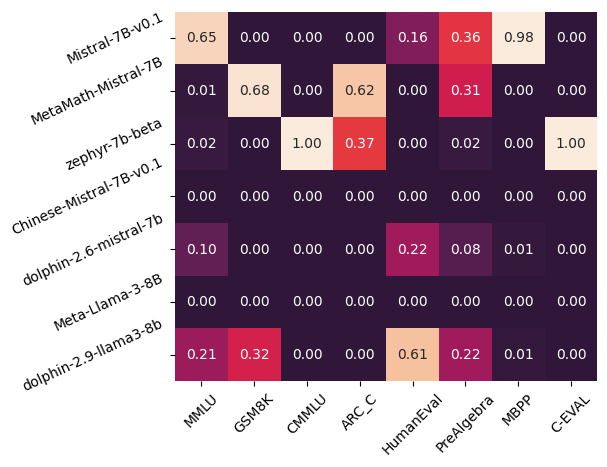

In [34]:
import seaborn as sns
models_name = ['Mistral-7B-v0.1','MetaMath-Mistral-7B',"zephyr-7b-beta",'Chinese-Mistral-7B-v0.1',"dolphin-2.6-mistral-7b", "Meta-Llama-3-8B", "dolphin-2.9-llama3-8b"]
dataset_name = ["MMLU", "GSM8K","CMMLU","ARC_C","HumanEval","PreAlgebra", "MBPP", "C-EVAL"]
sns.heatmap(distribution_matrix, square=True, annot=True, fmt='0.2f', xticklabels=dataset_name, yticklabels=models_name, cbar=False, vmin=-0.1, vmax=0.7)
plt.xticks(rotation=45)
plt.yticks(rotation=25)
# plt.savefig("/data/home/chensh/projects/LLM_router/figures/sample_distribution_v2.pdf", dpi=800, bbox_inches = 'tight')

In [7]:

import json

data_len_list = []
for file_path in dataset_paths:
    with open(file_path, 'r') as f:
        data_list = json.load(f)
        data_len_list.append(len(data_list))

all_sample_distribution = [0, 0, 0, 0, 0, 0, 0]
for j, per_model_distribution in enumerate(distribution_matrix):
    for i in range(5,8):
        all_sample_distribution[j] += per_model_distribution[i] * data_len_list[i]

print(all_sample_distribution)
all_sample_distribution = np.array(all_sample_distribution)
all_sample_distribution = all_sample_distribution / np.sum(all_sample_distribution) 
print(all_sample_distribution)

# np.sum( all_sample_distribution * np.array([416.4469283, 433.7455524, 404.0106289, 426.7654369, 414.8200222, 379.9586915, 319.6867065]))

np.sum( all_sample_distribution * np.array([258.8383127, 247.6017654, 257.8926255, 263.7625816, 192.1132418, 236.866828, 188.8286372]))

[15.0, 1409.74, 405.39000000000004, 237.53000000000003, 84.72, 102.93, 448.23]
[0.00554828 0.52144226 0.14994785 0.08785888 0.03133669 0.03807231
 0.16579374]


238.73532531713275